<a href="https://colab.research.google.com/github/deqg/deq/blob/main/Copy_of_deq_nips_final_relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for the paper "Exploring the Gaussian process nature of wide neural networks: insights from the deep equilibrium models"

In [1]:
import torch 
torch.manual_seed(4567) 
import torch.nn as nn
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
import math
import numpy as np
np.random.seed(4567)
device = 'cuda'


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Code from Greg Yang https://github.com/thegregyang/GP4A
def VErf(cov):
    '''
    Computes E[erf(z) erf(z)^T | z ~ N(0, `cov`)]
    where z is a multivariate Gaussian with mean 0 and covariance `cov`
    
    Inputs:
        `cov`: An array where the last 2 dimensions contain covariance matrix of z (and the first dimensions are "batch" dimensions)
    Output:
        a numpy array of the same shape as `cov` that equals the
        expectation above in the last 2 dimensions.
    '''
    ll = list(range(cov.shape[-1]))
    d = np.sqrt(cov[..., ll, ll] + 0.5)
    
    c = d[..., None]**(-1) * cov * d[..., None, :]**(-1)
    return 2./np.pi * np.arcsin(np.clip(c, -1, 1))

def VDerErf(cov):
    '''
    Computes E[erf'(z) erf'(z)^T | z ~ N(0, `cov`)]
    where erf' is the derivative of erf and
    z is a multivariate Gaussian with mean 0 and covariance `cov`
    
    Inputs:
        `cov`: An array where the last 2 dimensions contain covariance matrix of z (and the first dimensions are "batch" dimensions)
    Output:
        a numpy array of the same shape as `cov` that equals the
        expectation above in the last 2 dimensions.
    '''
    ll = list(range(cov.shape[-1]))
    d = np.sqrt(cov[..., ll, ll])
    dd = 1 + 2 * d
    return 4/np.pi * (dd[..., None] * dd[..., None, :] - 4 * cov**2)**(-1./2)

def J1(c, eps=1e-10):
    c[c > 1-eps] = 1-eps
    c[c < -1+eps] = -1+eps
    return (np.sqrt(1-c**2) + (np.pi - np.arccos(c)) * c) / np.pi

def VReLU(cov, eps=1e-5):
    ll = list(range(cov.shape[-1]))
    d = np.sqrt(cov[..., ll, ll])
    c = d[..., None]**(-1) * cov * d[..., None, :]**(-1)
    return torch.tensor(np.nan_to_num(0.5 * d[..., None] * J1(c, eps=eps) * d[..., None, :]))
	
def VStep(cov):
    '''
    Computes E[step(z) step(z)^T | z ~ N(0, `cov`)]
    where step is the function takes positive numbers to 1 and
    all else to 0, and 
    z is a multivariate Gaussian with mean 0 and covariance `cov`
    
    Inputs:
        `cov`: An array where the last 2 dimensions contain covariance matrix of z (and the first dimensions are "batch" dimensions)
    Output:
        a numpy array of the same shape as `cov` that equals the
        expectation above in the last 2 dimensions.
    '''
    ll = list(range(cov.shape[-1]))
    d = np.sqrt(cov[..., ll, ll])
    c = d[..., None]**(-1) * cov * d[..., None, :]**(-1)
    return 2./np.pi * np.arcsin(np.clip(c, -1, 1))

from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)



In [4]:
# Define the Vphi function
step = lambda x: torch.heaviside(x, values=0)
derf = lambda x: 2/np.sqrt(np.pi)*torch.exp(-x**2)
def Vphi(K,phi):
  if phi ==  torch.relu:
    return VReLU(K)
  elif phi == torch.erf:
    return VErf(K)
  elif phi == derf:
    return VDerErf(K)
  elif phi == step:
    return VStep(K)
  else:
    x_dis = torch.distributions.MultivariateNormal(torch.zeros(len(K[0])),K)
    x = x_dis.sample((100000,))
    z = phi(x)
    return torch.mean(torch.matmul(z[:,:,None],z[:,None,:]),axis=0)

Define the deep equilibrium model
$$	\begin{aligned}
		g^1(x)&=U^T x,\quad h^1(x)=\phi(g^1(x)),\\
		g^{\ell}(x) &= W^Th^{\ell-1},\quad 
		h^{\ell}(x) =\phi(g^{\ell}(x) + g^1(x)),\text{ for }\ell = 2, 3,\ldots, L-1.
	\end{aligned}
	\label{eq:finite-depth}
$$

In [5]:
class DEQ(nn.Module):
    def __init__(self, in_features, hdim, out_features, tol = 1e-4, max_iter=100, act = torch.relu,sigma_u=1,sigma_w=0.6,sigma_out=1, outlayer=False):
        super().__init__()
        self.l1 = nn.Linear(in_features, hdim, bias=False)
        self.l1.weight.data.normal_(0.0, sigma_u/((np.sqrt(self.l1.weight.shape[-1]))))
        self.linear = nn.Linear(hdim, hdim, bias=False)
        self.linear.weight.data.normal_(0.0, sigma_w/((np.sqrt(self.linear.weight.shape[-1]))))
        self.l2 = nn.Linear(hdim, out_features, bias=False)
        self.l2.weight.data.normal_(0.0, sigma_out/((np.sqrt(self.l2.weight.shape[-1]))))
        self.tol = tol
        self.max_iter = max_iter
        self.act = act
        self.out = outlayer
  
    def forward(self, x):
        # initialize output z to be zero
        x = self.l1(x)
        xx = x
        z = torch.zeros_like(x)
        self.iterations = 0

        # iterate until convergence
        while self.iterations < self.max_iter:
            z_next = self.act(self.linear(z) + x)
            self.err = torch.norm(z - z_next)
            z = z_next
            self.iterations += 1
            if self.tol is not None:
              if self.err < self.tol:
                  break
        if self.out == True:
          return self.l2(z)
        else:
          return self.linear(z)

In [6]:
sigma_out=1
# SET ACIVATION FUN
act = torch.relu

## Demonstrate the convergence of the fixed point
Generating Figure 1 (left)

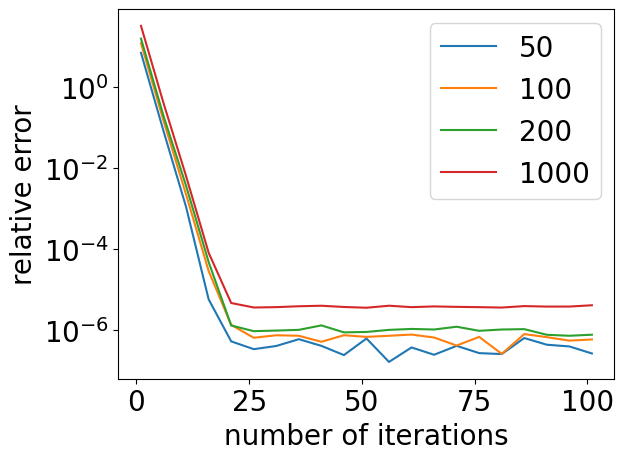

In [7]:
plt.rcParams.update({'font.size': 20})

x = torch.randn((2,10)).to(device)

for hdim in [50,100,200,1000]:
  errs = []
  for iter in range(1,105,5):
    model = DEQ(10,hdim,10,tol=None,act=act,max_iter=iter, sigma_w=0.6,outlayer=True).to(device)
    y = model(x)
    errs.append(model.err.detach().cpu())
    # print(f"Terminated after {model.iterations} iterations with error {model.err}")
  plt.semilogy(range(1,105,5),errs)
  plt.xlabel('number of iterations')
  plt.ylabel('relative error')
#   plt.ylabel('relative error \|h^{\ell+1} - h^\ell\|_{\ell^2}')
  plt.legend([50,100,200,1000])
  plt.savefig('fix.png',dpi=600,bbox_inches="tight")

## Demonstrate the Gaussian behavior
We take width to be 1000 and run simulations over 10000 neural networks and plot the output distributions.

Generate Figure 1 (right)

In [8]:
hdim = 1000
num_network = 10000
x = x.to(device)
errs = []
yyy = []
yya = []
for i in range(num_network):
  if i%100==0:
    print(i)
  model = DEQ(10,hdim,10,act=act,tol=1e-6, sigma_w=0.6,outlayer=True).to(device)
  y = model(x)

  ind = np.random.choice(range(len(y[0])),3,replace=False)
  yyy.append(y[:,0].detach().cpu().numpy())
  yya.append(y[:,ind].detach().cpu().numpy())
  errs.append(model.err.detach().cpu())


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [9]:
yyy = np.array(yyy)
yya = np.array(yya)

<ipython-input-10-fda164c9568a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yyy[:,0],axlabel=1)
<ipython-input-10-fda164c9568a>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zz,hist=False,axlabel=1)


KstestResult(statistic=0.006123402318586879, pvalue=0.845224730310915, statistic_location=-0.30541933, statistic_sign=-1)


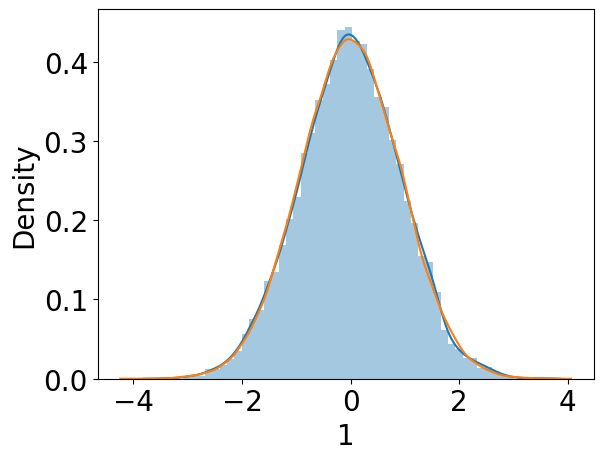

In [10]:
import seaborn as sns
import scipy
sns.distplot(yyy[:,0],axlabel=1)

zz = np.random.normal(0,np.std(yyy[:,0]),(100000,))
sns.distplot(zz,hist=False,axlabel=1)

print(scipy.stats.kstest((yyy[:,0]-yyy[:,0].mean())/yyy[:,0].std(),cdf=scipy.stats.norm.cdf))
plt.savefig('gaussian_1000.png',bbox_inches="tight")

Plot figure 1 (middle) for three neurons in the output

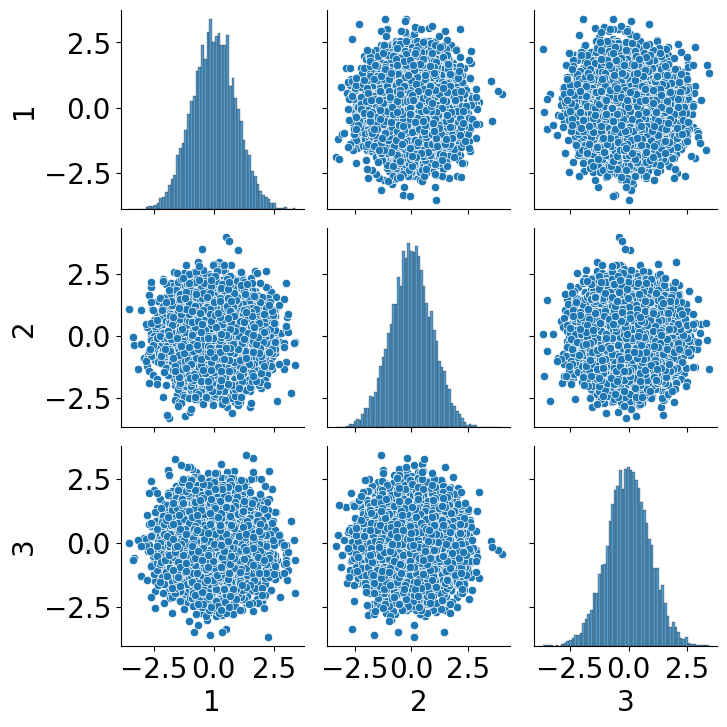

In [11]:
import pandas as pd
df = pd.DataFrame({'1':yya[:,0,0],'2':yya[:,0,1],'3':yya[:,0,2]})
sns.pairplot(df)
plt.savefig('pairplot.png',bbox_inches="tight")

Calculate the Gaussian Kernel using Corollary 4.2
$$		\Sigma^1(x,x^{'} )  = \sigma_u^2({x},x^{'})/n_{in},
		\Sigma^{\ell+1}(x,x^{'})  = \sigma_w^2
  \mathbb{E}\phi(u^{\ell}(x)  ) \phi(u^{\ell}(x^{'}) ),
	$$
	where $(u^{\ell}(x), u^{\ell}(x^{\prime}))$ follows a centered binary Gaussian distribution with covariance 
	$$
		\Sigma(u^{\ell}(x), u^{\ell}(x^{\prime}))
		=\begin{cases}
			\Sigma^1(x,x^{\prime}),  & \ell=1\\
			\Sigma^{\ell}(x,x^{\prime}) + \Sigma^{1}(x,x^{\prime}), & \ell\in [2,L-1]
		\end{cases}
	$$


In [12]:
sigma_w = 0.6
sigma_u=1
sigma_out=1
K0 = (x@x.T/len(x[0])).to(torch.float32).to('cpu')
K = K0 
lam =[]
for _ in range(100):
  K = Vphi(K,act)*sigma_w**2 + sigma_u**2*K0

K_thr = Vphi(K,act)*sigma_out**2


plot figure 2 (left)

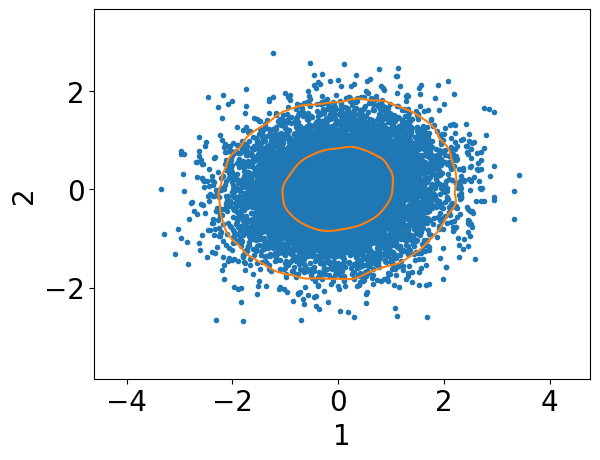

In [13]:
dis = torch.distributions.MultivariateNormal(loc=torch.zeros(2),covariance_matrix=K_thr[:2,:2])
import seaborn as sns
import pandas as pd
plt.plot(yyy[:,0],yyy[:,1],'.')
da = dis.sample((100000,))
df = pd.DataFrame(da)
sns.kdeplot(data=df,x=0,y=1,levels=3)

plt.xlabel('1')
plt.ylabel('2')
plt.savefig('gaussian.png',bbox_inches="tight")

## Convergence of covariance
We plot figure 2 (middle and right) of the covariance matrix using neural network simulations and Gaussian process computations

In [14]:
sigma_w = 0.6
sigma_u = 1
sigma_out = 1
hdim = 1000
number_network = 10000
device = 'cuda'
x = torch.randn((10,10)).to(device)

In [15]:
kk = []
for i in range(number_network):
    if i%100==0:
      print(i)
    with torch.no_grad():
        model = DEQ(10,hdim,10,act=act,tol=None,outlayer=False).to(device)
        y = model(x)
    kk.append(y.cov().detach().cpu())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [16]:
sigma_w = 0.6
K0 = (x@x.T/len(x[0])).to(torch.float32).to('cpu')
K = K0 
lam =[]
for _ in range(100):
  K = Vphi(K,act)*sigma_w**2 + sigma_u**2*K0

K_thr = Vphi(K,act)*sigma_w**2

In [17]:
kkk = 0
for kt in kk:
    kkk = kkk+ kt
kkk = kkk/len(kk)

tensor(3.1550e-06)


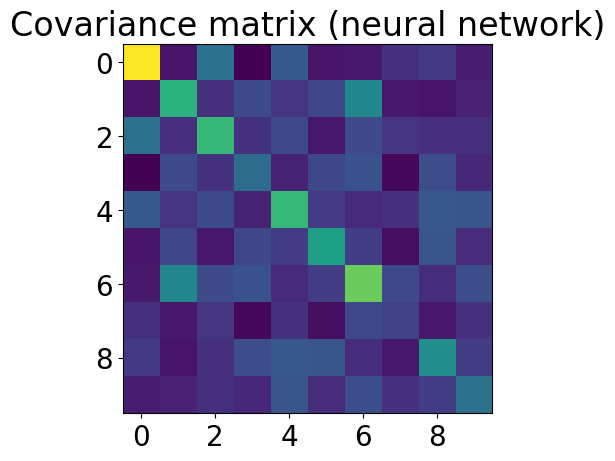

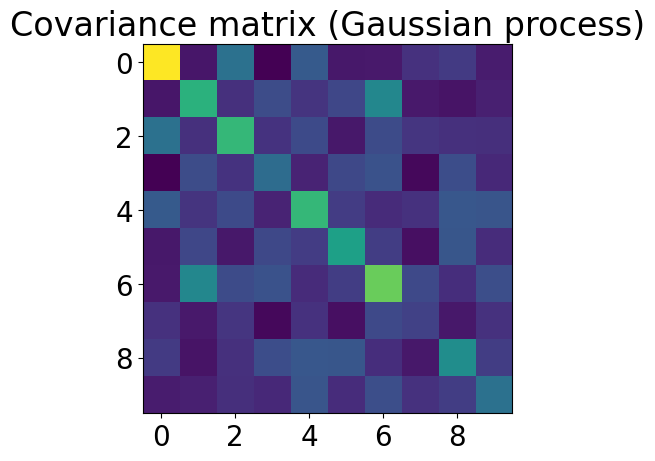

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)
# plt.subplots()
# plt.subplot(221)
plt.figure()
f1 = plt.imshow(kkk, cmap='viridis')#,vmin=-0.2,vmax=0.5)
plt.xticks([0,2,4,6,8])
plt.yticks([0,2,4,6,8])
plt.title('Covariance matrix (neural network)')
# plt.colorbar()
# plt.subplot(222)
plt.savefig('cov1.png',bbox_inches="tight")
plt.figure()
f2 = plt.imshow(K_thr, cmap='viridis')#,vmin=-0.2,vmax=0.5)
plt.xticks([0,2,4,6,8])
plt.yticks([0,2,4,6,8])
plt.title('Covariance matrix (Gaussian process)')
# plt.colorbar()
print(torch.mean((kkk-K_thr)**2)/torch.mean(K_thr**2))
plt.savefig('cov.png')
plt.savefig('cov2.png',bbox_inches="tight")
# plt.imshow(K_sim['5'])
# plt.colorbar()
# plt.figure()
# plt.imshow(K_thr)
# plt.colorbar()
# torch.mean((K_sim[0]-K_thr)**2/K_thr**2)

## width and depth dependence
We plot the different between  $$ \|((h_n^\ell(x),h_n^\ell(x'))/n- \Sigma^*)\|_{\ell^2} / \|\Sigma^*\|_{\ell^2}$$
where $\Sigma^*$ is computed using the Gaussian process with 100 iterations (enough for reaching fixed point) and $h_n^\ell$ are computed using neural networks


In [19]:
sigma_w = 0.6
sigma_u = 1
sigma_out = 1
hdim = 1000
number_network = 1000

In [20]:
device = 'cuda'
x = torch.randn((10,10)).to(device)

In [21]:
widths = [2**i for i in range(5, 13)]
K_sim  = {}
kk = []
for width in widths:
  kk = []
  for i in range(number_network):
    if i%100==0:
      print(i)
    with torch.no_grad():
        model = DEQ(10,width,10,act=act,tol=None,outlayer=False).to(device)
        y = model(x)
        # ya[i] = y
    # xa[i] = xx
    kk.append(y.cov().detach().cpu())
  K_sim[width] = kk


0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [22]:
def K_init(x,phi):
    WW = phi(torch.randn((10000,10))@x.T)
    return WW.T.cov() 

In [23]:
sigma_w = 0.6
K0 = (x@x.T/len(x[0])).to(torch.float32).to('cpu')
K = K0 
lam =[]
for _ in range(100):
  K = Vphi(K,act)*sigma_w**2 + sigma_u**2*K0

K_thr = Vphi(K,act)*sigma_w**2

In [24]:
import pandas as pd
frobs = []
for width in widths:
    _frobs = np.array([torch.sum((K_sim[width][i] - K_thr)**2) / torch.linalg.norm(K_thr)**2 for i in range(100)])
    for f in _frobs:
        frobs.append(dict(
            relfrob=f,
            width=width
        ))

In [25]:
frob_df = pd.DataFrame(frobs)

Plot figure 3 (first from left)

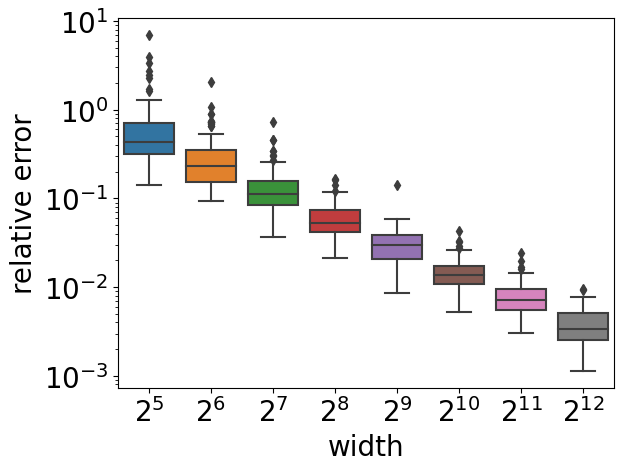

In [26]:
import seaborn as sns

sns.boxplot(x='width', y='relfrob', data=frob_df)
plt.semilogy()
plt.xticks([0,1,2,3,4,5,6,7],['$2^5$','$2^6$','$2^7$','$2^8$','$2^9$','$2^{10}$','$2^{11}$','$2^{12}$'])
# plt.xticks([2**5,2**6,2**7,2**8,2**9,2**10,2**11,2**12])
plt.ylabel('relative error')
# plt.legend()
# plt.title('Deviation From Infinite-width Theory')
# _ = plt.ylabel(u'Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')
plt.savefig('cov_width.png',bbox_inches="tight")

Plot figure 3 (second from left)

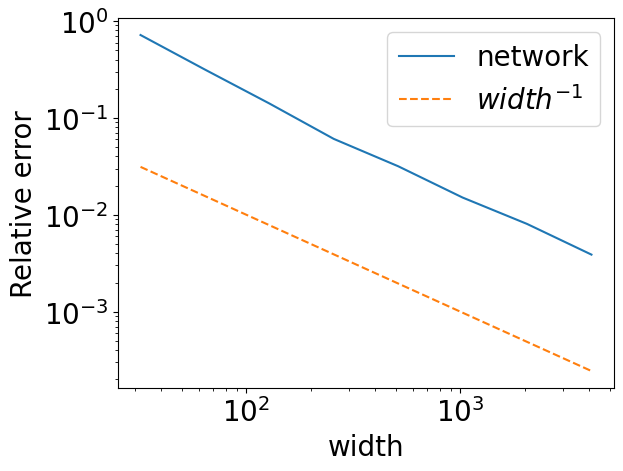

In [27]:
frob_df.groupby('width', as_index=False).mean().plot.line(x='width', y='relfrob')
plt.plot(widths, np.array(widths, dtype='float')**-1, '--', label=u'${width}^{-1}$')
# plt.ylabel(u'Mean Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')
plt.ylabel('Relative error')
plt.loglog()
plt.legend(['network',u'${width}^{-1}$'])
# _ = plt.title(u'Deviation from theory in (Frobenius norm)$^2$ drops like $width^{-1}$')
plt.savefig('cov_wdith1.png',bbox_inches="tight")

depths dependence

In [28]:
depths = range(10)
width = 1000
number_network = 1000
K_sim_depth  = {}
kk = []
for depth in depths:
  kk = []
  for i in range(number_network):
    if i%100==0:
      print(i)
    with torch.no_grad():
        model = DEQ(10,width,10,act=act,tol=None,max_iter=depth,outlayer=False).to(device)
        y = model(x)
    kk.append(y.cov().detach().cpu())
  K_sim_depth[depth] = kk


0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [29]:
import pandas as pd
frobs = []
for depth in depths:
    _frobs = np.array([torch.sum((K_sim_depth[depth][i] - K_thr)**2) / torch.linalg.norm(K_thr)**2 for i in range(100)])
    for f in _frobs:
        frobs.append(dict(
            relfrob=f,
            depth=depth
        ))

Plot figure 3 (third and fourth from left)

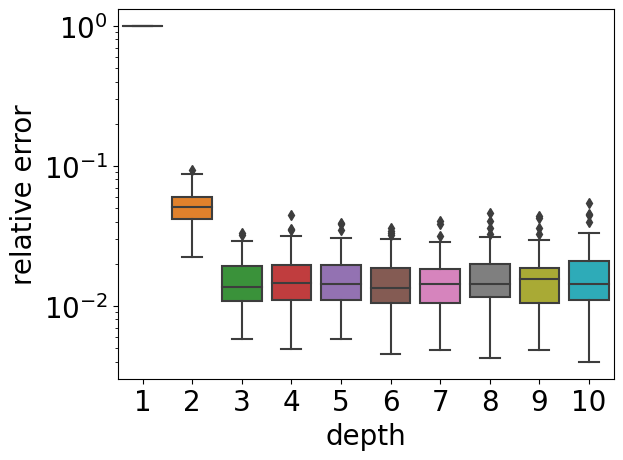

In [30]:
frob_df = pd.DataFrame(frobs)
import seaborn as sns
sns.boxplot(x='depth', y='relfrob', data=frob_df)
plt.semilogy()
plt.ylabel('relative error')
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])
plt.savefig('cov_depth.png',bbox_inches="tight")

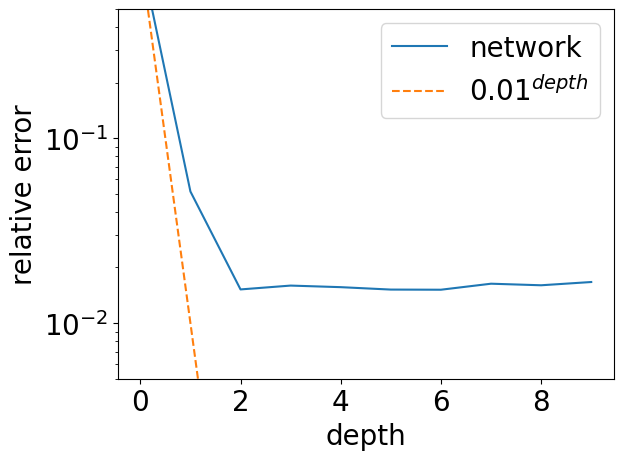

In [31]:
frob_df.groupby('depth', as_index=False).mean().plot.line(x='depth', y='relfrob')
plt.plot(depths, 0.01**(np.array(depths, dtype='float')), '--', label=u'${0.01}^{depth}$')
plt.ylim([5*10**(-3),0.5])
plt.ylabel(u'Mean Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')
plt.semilogy()
plt.legend(['network','$0.01^{depth}$'])
plt.ylabel('relative error')
plt.savefig('cov_depth1.png',bbox_inches="tight")

# Positive definiteness of the kernel matrix
We demonstrate the positive definiteness of $\Sigma^*$ using:
    1. The Gaussian process 
    2. The neural network simulations

The smallest eigenvalue over Gaussian process iterations (Figure 4, first from left)

In [32]:
sigma_w = 0.6

K0 = (x@x.T/len(x[0])).to(torch.float32).to('cpu')
K = K0 
lam =[]
for _ in range(100):
  K = Vphi(K,act)*sigma_w**2 + sigma_u**2*K0
  lam.append(torch.tensor([i.real for i in torch.linalg.eigvals(Vphi(K,act))]).min())



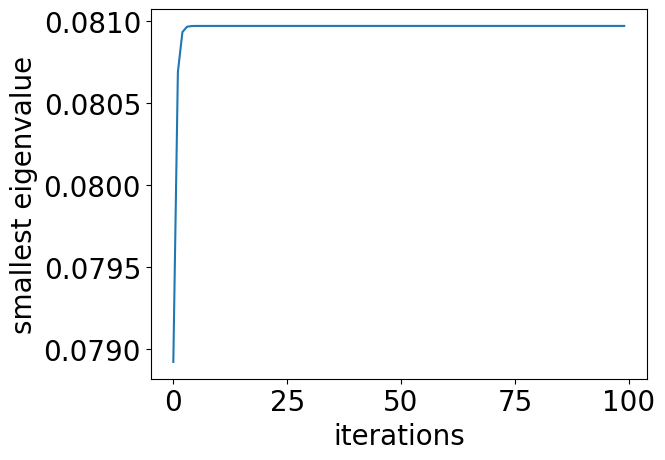

In [33]:
plt.plot(lam)
plt.xlabel('iterations')
plt.ylabel('smallest eigenvalue')
plt.savefig('lam.png',bbox_inches="tight")


Smallest eigenvalue of the matrix computed using neural networks for different widths (Figure 4, third from left)

[32, 64, 128, 256, 512, 1024, 2048, 4096] [tensor(0.0247), tensor(0.0403), tensor(0.0626), tensor(0.0722), tensor(0.0672), tensor(0.0790), tensor(0.0795), tensor(0.0835)]


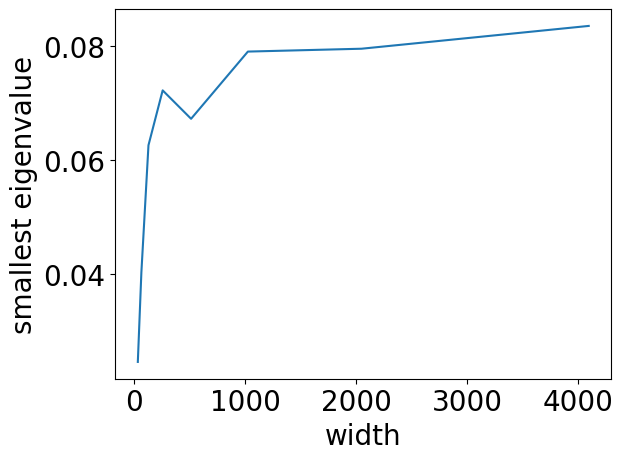

In [34]:
lam_sim = []
for width in widths:
    lam_sim.append(torch.tensor([i.real for i in torch.linalg.eigvals(K_sim[width][0]/sigma_w**2)]).min())
plt.plot(widths,lam_sim)
print(widths,lam_sim)
plt.xlabel('width')
plt.ylabel('smallest eigenvalue')
plt.savefig('lam_sim_width.png',bbox_inches="tight")

dependence of the eigenvalue with $\sigma_w$, computed using Gaussian process (Figure 4, last from left)

In [35]:
sigma_ww = np.linspace(0.1,1,10)
lam =[]

for sigma_w in sigma_ww:
    print(sigma_w)
    K0 = (x@x.T/len(x[0])).to(torch.float32).to('cpu')
    K = K0 
    for _ in range(100):
      K = Vphi(K,act)*sigma_w**2 + sigma_u**2*K0
    lam.append(torch.tensor([i.real for i in torch.linalg.eigvals(Vphi(K,act))]).min())

    

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


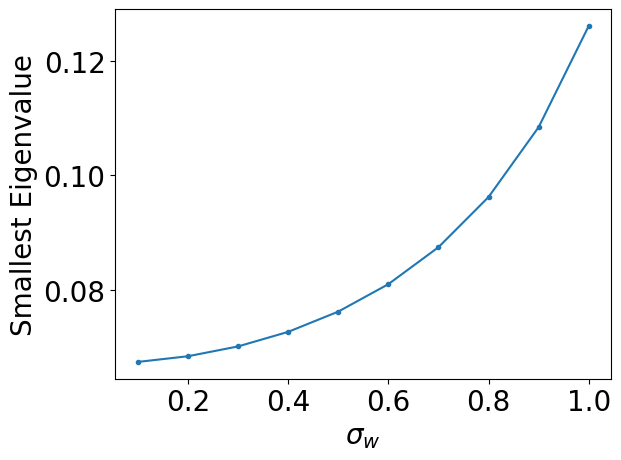

In [36]:
plt.plot(sigma_ww,lam,'.-')
plt.xlabel('$\sigma_w$')
plt.ylabel('Smallest Eigenvalue')
plt.savefig('lam_eig_sigma.png',bbox_inches="tight")

smallest eigenvalue of large width neural network over different depths (Figure 4, second from left)

In [37]:
sigma_w = 0.6
width = 1000
number_network = 1000
lamlam = []
for i in range(number_network):
    if i%100==0:
      print(i)
    with torch.no_grad():
        model = DEQ(10,width,10,act=act,tol=None,max_iter=depth,outlayer=False).to(device)
        y = model(x)
    kk = (y.cov().detach().cpu())
    lamlam.append(torch.tensor([i.real for i in torch.linalg.eigvals(kk/sigma_w**2)]).min())


0
100
200
300
400
500
600
700
800
900


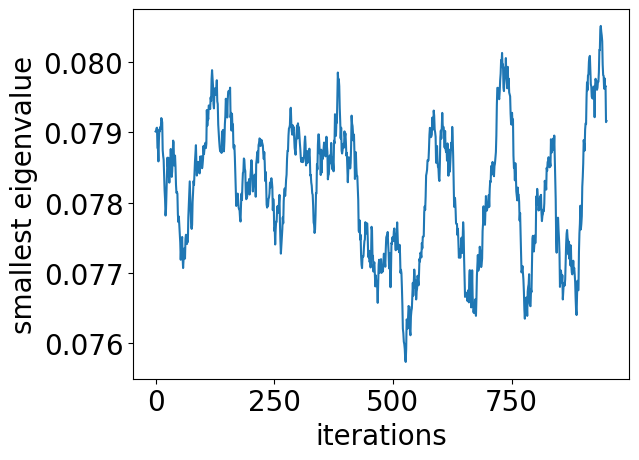

In [38]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot( moving_average(lamlam, 50))
plt.xlabel('iterations')
plt.ylabel('smallest eigenvalue')
plt.savefig('lamlam.png',bbox_inches="tight")


## Gaussian behavior for neural networks  as width increase
We demonstrate that as the width of the neural network increase, the distribution of the first neuron in $h^L$ fits the Gaussian distribution better 

KstestResult(statistic=0.12166218864115053, pvalue=1.8898673940944358e-129, statistic_location=0.51132375, statistic_sign=1)
KstestResult(statistic=0.013733916707310279, pvalue=0.04557004566632916, statistic_location=0.35489556, statistic_sign=1)
KstestResult(statistic=0.01273432560788157, pvalue=0.07740480713372933, statistic_location=0.64293134, statistic_sign=1)
KstestResult(statistic=0.006967990163608162, pvalue=0.7138018082854763, statistic_location=-0.04019711, statistic_sign=-1)
KstestResult(statistic=0.005645292796869511, pvalue=0.905650175055594, statistic_location=-0.789689, statistic_sign=1)


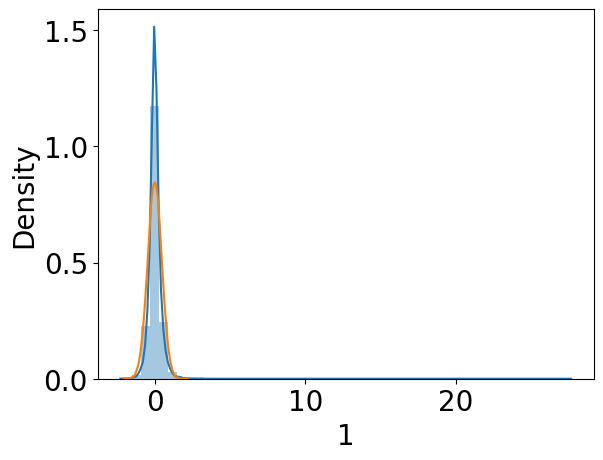

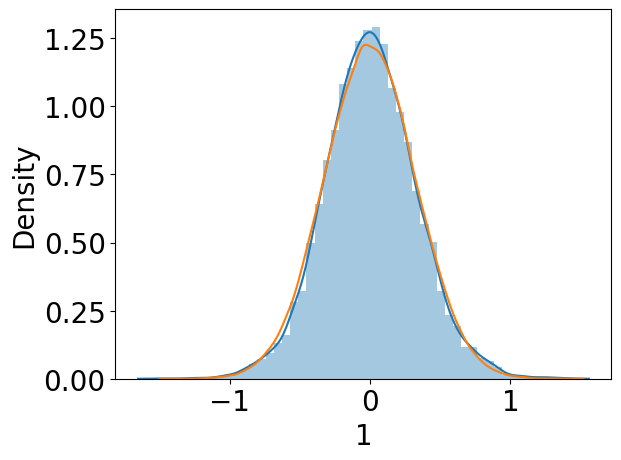

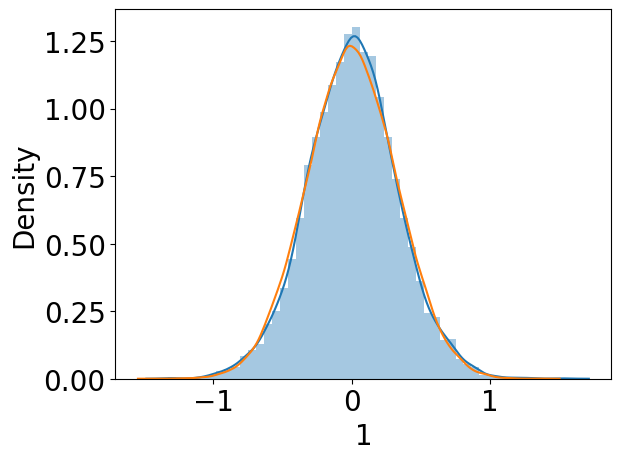

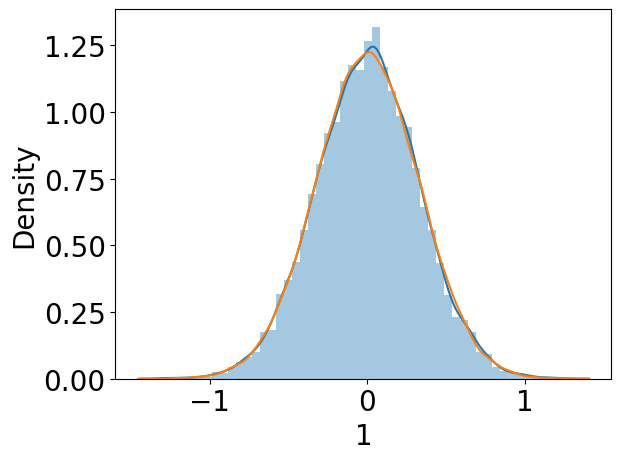

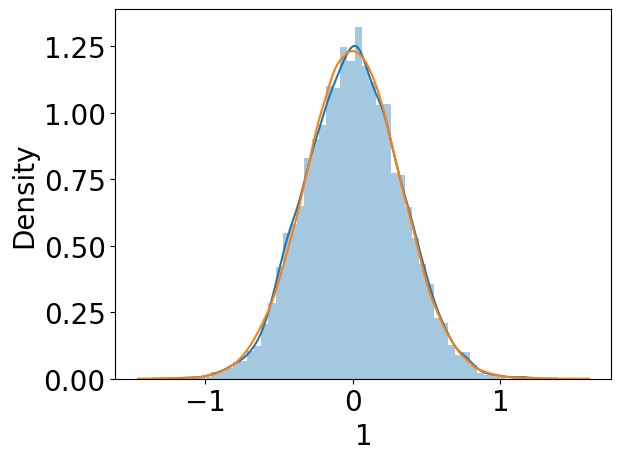

In [39]:
import warnings
warnings.filterwarnings("ignore")
x = torch.rand((2,10)).to(device)

for hdim in [10,50,100,500,1000]:
  num_network = 10000
  sigma_out = 1
  errs = []
  yyy = []
  yya = []
  for _ in range(num_network):
    model = DEQ(10,hdim,10,act=act,tol=1e-6, sigma_w=0.6,outlayer=False).to(device)
    y = model(x)

    ind = np.random.choice(range(len(y[0])),3,replace=False)
    yyy.append(y[:,0].detach().cpu().numpy())
    yya.append(y[:,ind].detach().cpu().numpy())
    errs.append(model.err.detach().cpu())
  yyy = np.array(yyy)
  yya = np.array(yya)
  import seaborn as sns
  import scipy
  plt.figure()
  sns.distplot(yyy[:,0],axlabel=1)

  zz = np.random.normal(0,np.std(yyy[:,0]),(100000,))
  sns.distplot(zz,hist=False,axlabel=1)

  print(scipy.stats.kstest((yyy[:,0]-yyy[:,0].mean())/yyy[:,0].std(),cdf=scipy.stats.norm.cdf))
  plt.savefig('gaussian_%d.png'%hdim,bbox_inches="tight")
  